Bengaluru house price prediction

import library

In [4]:
import numpy as np 
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
import matplotlib.pyplot as plt 
import pandas as pd


In [5]:
df = pd.read_csv("../CSV file/bengaluru.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


Data cleaning

In [6]:
#remove unused column
df.drop(["availability", "society", "area_type"], axis="columns", inplace=True)

#look unique values each columns
for col in df:
    print(f"{col} : {df[col].unique()}")

#check for null values
df.isnull().sum()

#drop null value
df = df.dropna()
df.isnull().sum()

location : ['Electronic City Phase II' 'Chikka Tirupathi' 'Uttarahalli' ...
 '12th cross srinivas nagar banshankari 3rd stage' 'Havanur extension'
 'Abshot Layout']
size : ['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom' '2 Bedroom' '7 Bedroom' '5 BHK' '7 BHK'
 '6 BHK' '5 Bedroom' '11 BHK' '9 BHK' nan '9 Bedroom' '27 BHK'
 '10 Bedroom' '11 Bedroom' '10 BHK' '19 BHK' '16 BHK' '43 Bedroom'
 '14 BHK' '8 BHK' '12 Bedroom' '13 BHK' '18 Bedroom']
total_sqft : ['1056' '2600' '1440' ... '1133 - 1384' '774' '4689']
bath : [ 2.  5.  3.  4.  6.  1.  9. nan  8.  7. 11. 10. 14. 27. 12. 16. 40. 15.
 13. 18.]
balcony : [ 1.  3. nan  2.  0.]
price : [ 39.07 120.    62.   ...  40.14 231.   488.  ]


location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

from the dataset, we know that the size column can be converted into a number, so I will convert the size to be measured by the number of House BHK

In [7]:
#remove text from size column
df["bhk"] = df["size"].apply(lambda x: int(x.split(' ')[0]))
df

#search impossible value
df["bhk"].unique()
df[df.bhk > 20]

,location,size,total_sqft,bath,balcony,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,0.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,0.0,660.0,43


total_sqft cannot be converted directly to a number because there is data that is a range value, we will convert the range value first to the average value then convert it to number datatype

In [8]:
#range value detect
df.total_sqft.unique()

#function for filterized range value
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

#range value
df[df["total_sqft"].apply(is_float) == False]

#Range to average value
def converter(x):
    token = x.split("-")
    if len(token) == 2:
        x = (float(token[0]) + float(token[1]))/2
    try:
        return float(x)
    except:
        return None

#convert range to 1 value
df["sqft"] = df.total_sqft.apply(converter)

reduce number of unique data in location column by grouping unique data less than 10 into other

In [9]:
#make other categories for minority location dataset
lst = df.groupby("location")["location"].agg("count")
lstless = lst[lst<10]

#apply other function
df.location = df.location.apply(lambda x: "other" if x in lstless else x)
len(df.location.unique())

df.head()

,location,size,total_sqft,bath,balcony,price,bhk,sqft
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,2,1056.0
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,4,2600.0
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,3,1440.0
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,3,1521.0
4,Kothanur,2 BHK,1200,2.0,1.0,51.00,2,1200.0


make the price per sqft for later detecting extreme values which can be biased on the training process

In [10]:
#make price_per_sqft column for house
df["price_per_sqft"] = df.price*100000/df.sqft
df.head()

,location,size,total_sqft,bath,balcony,price,bhk,sqft,price_per_sqft
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,2,1056.0,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,4,2600.0,4615.384615
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,3,1440.0,4305.555556
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,3,1521.0,6245.890861
4,Kothanur,2 BHK,1200,2.0,1.0,51.00,2,1200.0,4250.000000


Outliers removal

there is impossible to have bedroom less than 300sqft/bedroom (based on instruction), I will remove this kind impossible value

In [11]:
#total bedroom unmatch with total sqft (300 per bedroom)
df = df[df.sqft/df.bhk>300]

I will remove the outliers data based on house location price per sqft (more than mean - standart deviation and less than mean + standart deviation)

In [12]:
#too cheap/expensive price_per_sqft based on location (extreme value will remove to reduce bias)
df.price_per_sqft.describe()

#function to remove outliers based on location (std deviation)
def outlierRem(df):
    df_out = pd.DataFrame()
    for key, sub in df.groupby("location"):
        mean = np.mean(sub.price_per_sqft)
        std = np.std(sub.price_per_sqft)
        reducer = sub[(sub.price_per_sqft>(mean-std)) & (sub.price_per_sqft<=(mean+std))]
        df_out = pd.concat([df_out, reducer], ignore_index=True)
    return df_out

df = outlierRem(df)
df.shape

(9655, 9)

there is impossible for house with 2 BHK have higher price than 3 BHK in same distric location, so i will remove it

First make scatter plot for knowing how much 2 BHK house which have higher price than 3 BHK and we will compare it with data after standarization

In [13]:
#outlier detection using visualization
def plotter(df, location):
    bhk2 = df[(df.location == location) & (df.bhk==2)]
    bhk3 = df[(df.location == location) & (df.bhk==3)]
    matplotlib.rcParams["figure.figsize"] = (15,10)
    plt.scatter(bhk2.sqft, bhk2.price, color="blue", label="2 BHK", s=50)
    plt.scatter(bhk3.sqft, bhk3.price, color="green", label="3 BHK", s=50)
    plt.xlabel("Total sqft")
    plt.ylabel("Price per sqft")
    plt.title(location)
    plt.legend()

here is Rajaji nagar house price distribution, there is many house with 2 BHK more expensive than 3 BHK

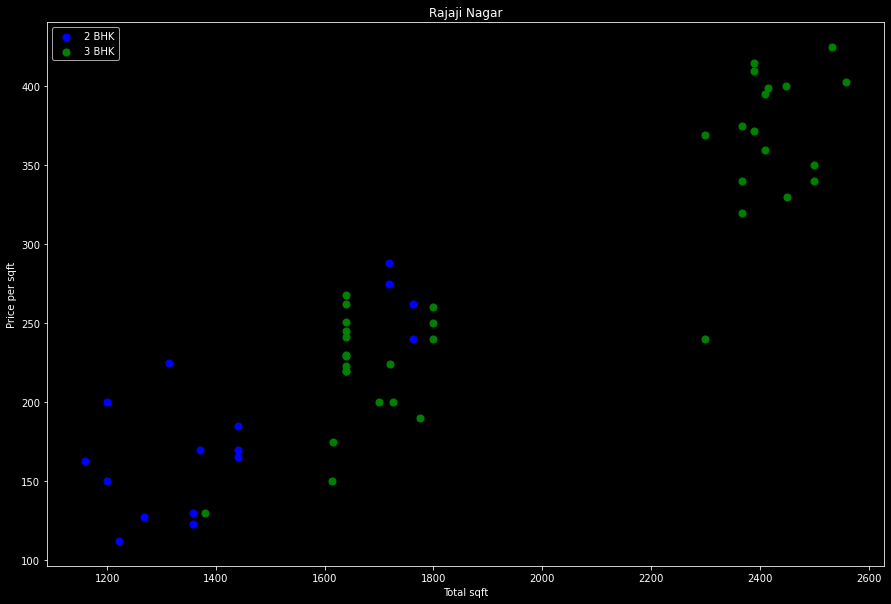

In [14]:
plotter(df, "Rajaji Nagar")

standarized 2 BHK house with higher Price

In [15]:

#remove 2 BHK house that have higher price than 3 BHK
def bhkoutliers(df):
    exc = np.array([])
    for location, location_df in df.groupby("location"):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby("bhk"):
            bhk_stats[bhk] = {
                "mean" : np.mean(bhk_df.price_per_sqft),
                "std" : np.std(bhk_df.price_per_sqft),
                "count" : bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby("bhk"):
            stats = bhk_stats.get(bhk-1)
            if stats and stats["count"]>5:
                exc = np.append(exc, bhk_df[bhk_df.price_per_sqft<(stats["mean"])].index.values)

    return df.drop(exc, axis="index")

df = bhkoutliers(df)
df.shape

(6948, 9)

Here Rajaji nagar house price distribution after standarized process

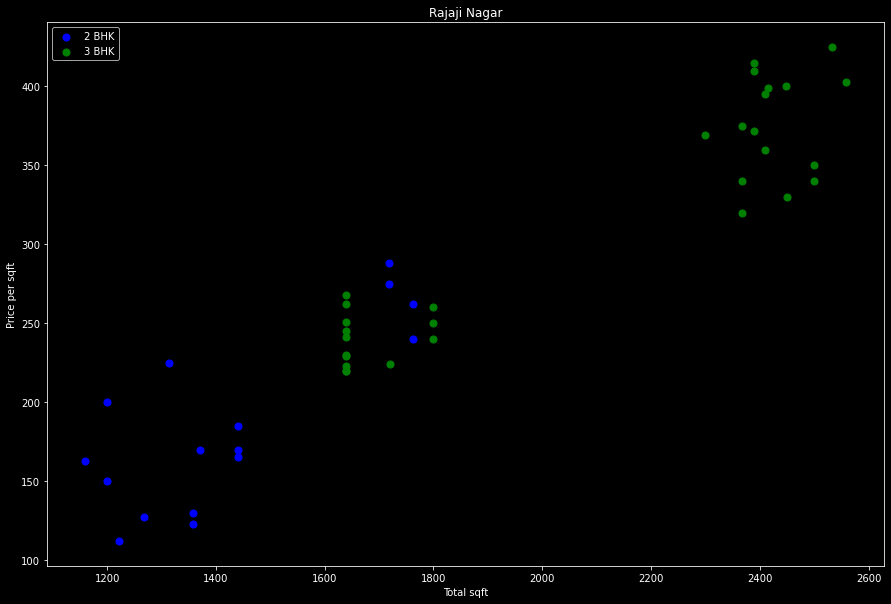

In [16]:
#visualization after unmakesense outlier removal
plotter(df, "Rajaji Nagar")

price distribution after standarized

(array([ 530., 3506., 2173.,  401.,  207.,   72.,   40.,   11.,    4.,
           4.]),
 array([ 1300.        ,  3620.98039216,  5941.96078431,  8262.94117647,
        10583.92156863, 12904.90196078, 15225.88235294, 17546.8627451 ,
        19867.84313725, 22188.82352941, 24509.80392157]),
 <BarContainer object of 10 artists>)

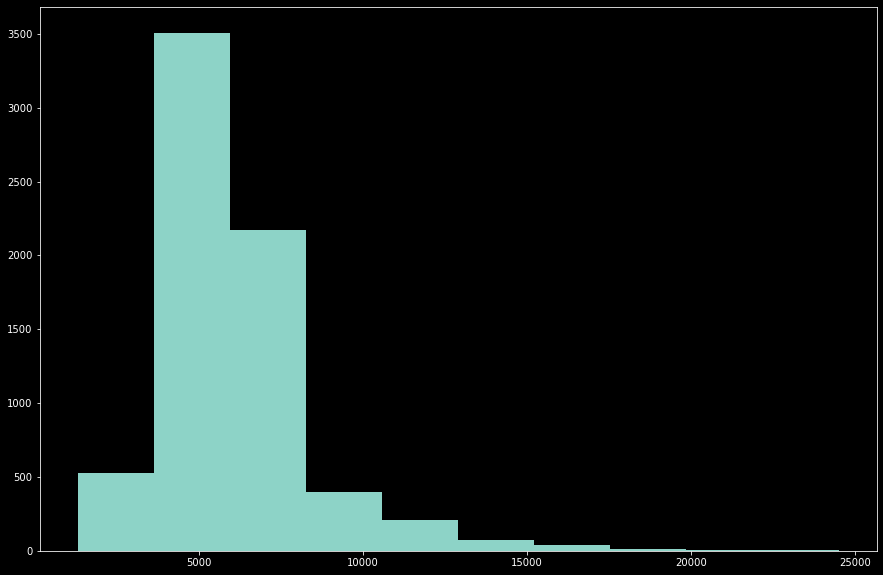

In [17]:
#visualization price per sqft distribution
import matplotlib
plt.hist(df.price_per_sqft)

now there is more outlier, impossible for house have more bathroom than bedroom (On Instruction), we will remove it 

In [18]:
#outlier removal logical - bath isnt more than bedroom
df.bath.unique()
df = df[df.bath<df.bhk+2]
df.shape

,location,bath,price,bhk,sqft
1,Devarachikkanahalli,2.0,40.0,2,1250.0
2,Devarachikkanahalli,2.0,83.0,2,1200.0
3,Devarachikkanahalli,2.0,40.0,2,1170.0
4,Devarachikkanahalli,2.0,65.0,3,1425.0
5,Devarachikkanahalli,2.0,43.0,2,947.0
...,...,...,...,...,...
9645,other,2.0,64.0,2,1155.0
9647,other,2.0,70.0,2,1200.0
9648,other,1.0,200.0,1,1800.0
9651,other,2.0,110.0,2,1353.0


Now i will drop columns that dont have impact for house price

In [ ]:
#remove unused column
df.head()
df.drop(["balcony", "total_sqft", "size", "price_per_sqft"], axis="columns", inplace=True)
df

One hot Encoding string data 

In [19]:
#convert string to numerical
dums = pd.get_dummies(df.location)
df = pd.concat([df, dums.drop("other", axis="columns")], axis="columns")
df.drop("location", axis="columns", inplace=True)
df.head()

,bath,price,bhk,sqft,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,2.0,40.0,2,1250.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,83.0,2,1200.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,40.0,2,1170.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,65.0,3,1425.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,43.0,2,947.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


separate dependent and independent variable

In [20]:
x = df.drop("price", axis='columns')
y = df.price

from sklearn.model_selection import train_test_split
xtr, xte, ytr, yte = train_test_split(x, y, test_size=.3, random_state=10)

Make machine learning linear regression

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso


def find_best(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best(x,y)

,model,best_score,best_params
0,linear_regression,0.839029,{'normalize': True}
1,lasso,0.715242,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.710879,"{'criterion': 'mse', 'splitter': 'random'}"


we will use Linear regression for algorithm because have higher score on gridsearchcv

In [24]:
lr.fit(xtr, ytr)
lr.predict(xte)
lr.score(xte, yte)


0.793210647583568

Prediction Functions

In [31]:
def predict_price(location, sqft, bath, bhk):
    locs = np.where(x.columns==location)[0][0]

    X = np.zeros(len(x.columns))
    X[0] = sqft
    X[1] = bath
    X[2] = bhk
    if locs >= 0:
        X[locs] = 1

    return lr.predict([X])[0]
 
predict_price("Rajaji Nagar", 1250, 2, 4)

,bath,bhk,sqft,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
9541,1.0,1,500.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5296,2.0,2,1185.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2521,2.0,2,1027.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,4.0,4,1500.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4478,1.0,1,850.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,2.0,2,1275.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5340,2.0,2,1185.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2790,3.0,3,1718.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5864,2.0,2,1200.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
